pip install wavio

pip install audio2numpy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import wavio
from audio2numpy import open_audio

# Auto-tuner

Auto-Tune uses a proprietary device to measure and alter pitch in vocal and instrumental music recording and performances. To apply auto-tuning we use the frequency shift property as indicated in page 478 of the book 
Digital Signal Processing de John. G Proakis y Dimitris G. Manolakis, 2007:

$$
x(n)e^{j2\pi ln/N} \quad \longrightarrow \quad X(k-l)
$$
We will use DFT for the initial tests and then we will deploy Fast Fourier Transform  (FFT) 


In [5]:
def FT_general_point(x,k,N):
    n = np.array(range(N))
    exps = np.exp(-1j*2*np.pi*k*n/N)
    return np.dot(x,exps)

def FT_general(x):
    N = x.shape[0]
    X = np.array([FT_general_point(x,k,N) for k in range(N)])
    return X

We demonstrate how the frequency shift property works for a gaussian signal as shown in the following figure. 

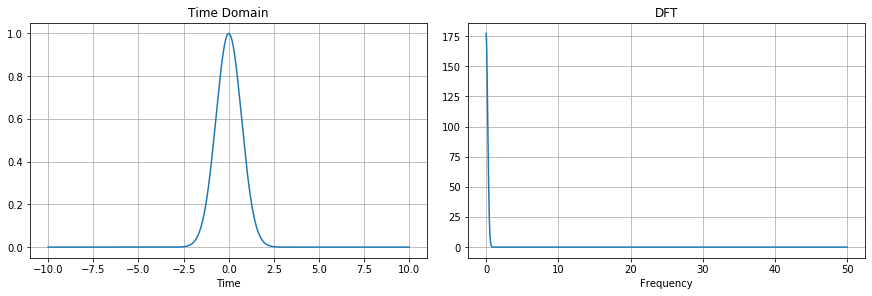

In [6]:
fs = 100

a = 1
n = np.arange(-10, 10, 1/fs)

samples = n.shape[0]

x = np.exp(-a*np.power(n,2))

fig, (ax0, ax1) = plt.subplots(ncols = 2,
                               constrained_layout = True,
                               figsize = (12,4))

ax0.plot(n, x)
ax0.set_title('Time Domain')
ax0.grid()
ax0.set_xlabel('Time')

X = FT_general(x)
Mg = np.abs(X)

ax1.plot(np.linspace(0,fs,x.shape[0])[0:int(x.shape[0]/2)],Mg[0:int(x.shape[0]/2)])
ax1.set_title('DFT')
ax1.grid()
ax1.set_xlabel('Frequency');

By shifting the frequency by 30 Hz, we obtain:

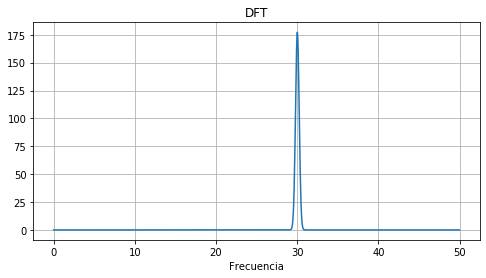

In [7]:
f0 = 30
x = np.exp(2j*np.pi*f0*n)*x

X = FT_general(x)
Mg = np.abs(X)

fig, ax = plt.subplots(figsize = (8,4))

ax.plot(np.linspace(0,fs,x.shape[0])[0:int(x.shape[0]/2)],Mg[0:int(x.shape[0]/2)])
ax.set_title('DFT')
ax.grid()
ax.set_xlabel('Frecuencia');

By shifting the frequency by 15 Hz, we obtain:

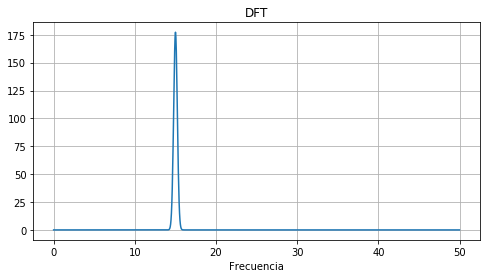

In [8]:
f0 = -15
x = np.exp(2j*np.pi*f0*n)*x

X = FT_general(x)
Mg = np.abs(X)

fig, ax = plt.subplots(figsize = (8,4))

ax.plot(np.linspace(0,fs,x.shape[0])[0:int(x.shape[0]/2)],Mg[0:int(x.shape[0]/2)])
ax.set_title('DFT')
ax.grid()
ax.set_xlabel('Frecuencia');

These examples demonstrate that the shift frequency property was correctly implemented. Now, it is going to be applied to audio signals. 

## Description of audio signals

We edit two audio signals in such a way that they will follow the melody Do, Mi, Sol, Do, Sol, Mi, Do.
These signals contain frequency values close to those desired frequencies to decrease the distortion created by the frequency shift. The desired musical notes are:


|Note|Frequency (Hz)|
|---|---|
|Do3|130.81|
|Mi3|164.81|
|Sol3|196.00|
|Do4|261.63|

Fuente:
https://pages.mtu.edu/~suits/notefreqs.html

## Audio signal 1 (Voice)

Se carga la señal de audio llamada "aud1.mp3"

In [9]:
signal, sampling_rate = open_audio('aud1.mp3')
total_size = signal.shape[0]
t = np.arange(0, total_size/sampling_rate, 1/sampling_rate)
inds = np.arange(0,total_size)

signal_cambiada_real = signal.copy()
signal_cambiada_im = signal.copy()
print("sampling rate:",sampling_rate)

sampling rate: 16000


We plot the signal in time domain to identify in the signal vector the location of each section of interest (musical note).

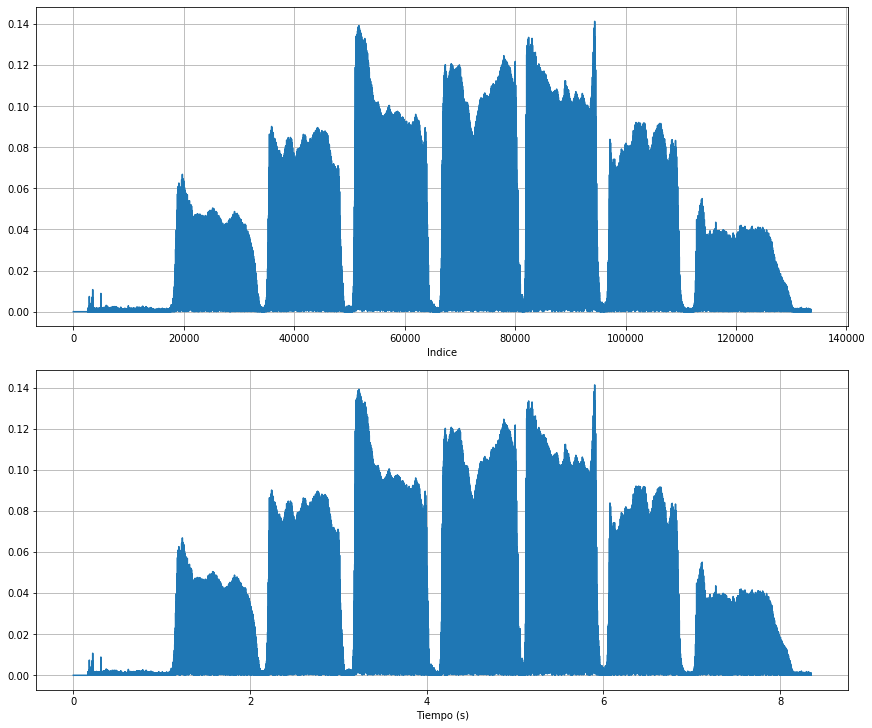

In [10]:
ini = 0
fin = total_size

fig, (ax0, ax1) = plt.subplots(nrows=2, constrained_layout=True, figsize = (12,10))

Mg = np.abs(signal)

ax0.plot(inds[ini:fin],Mg[ini:fin])
ax0.set_xlabel('Indice')
ax0.grid();

ax1.plot(t[ini:fin],Mg[ini:fin])
ax1.set_xlabel('Tiempo (s)')
ax1.grid();

Once we have the indices of the identified sections, we proceed to analyze the frequency spectrum for each  section and identify the most significant component.

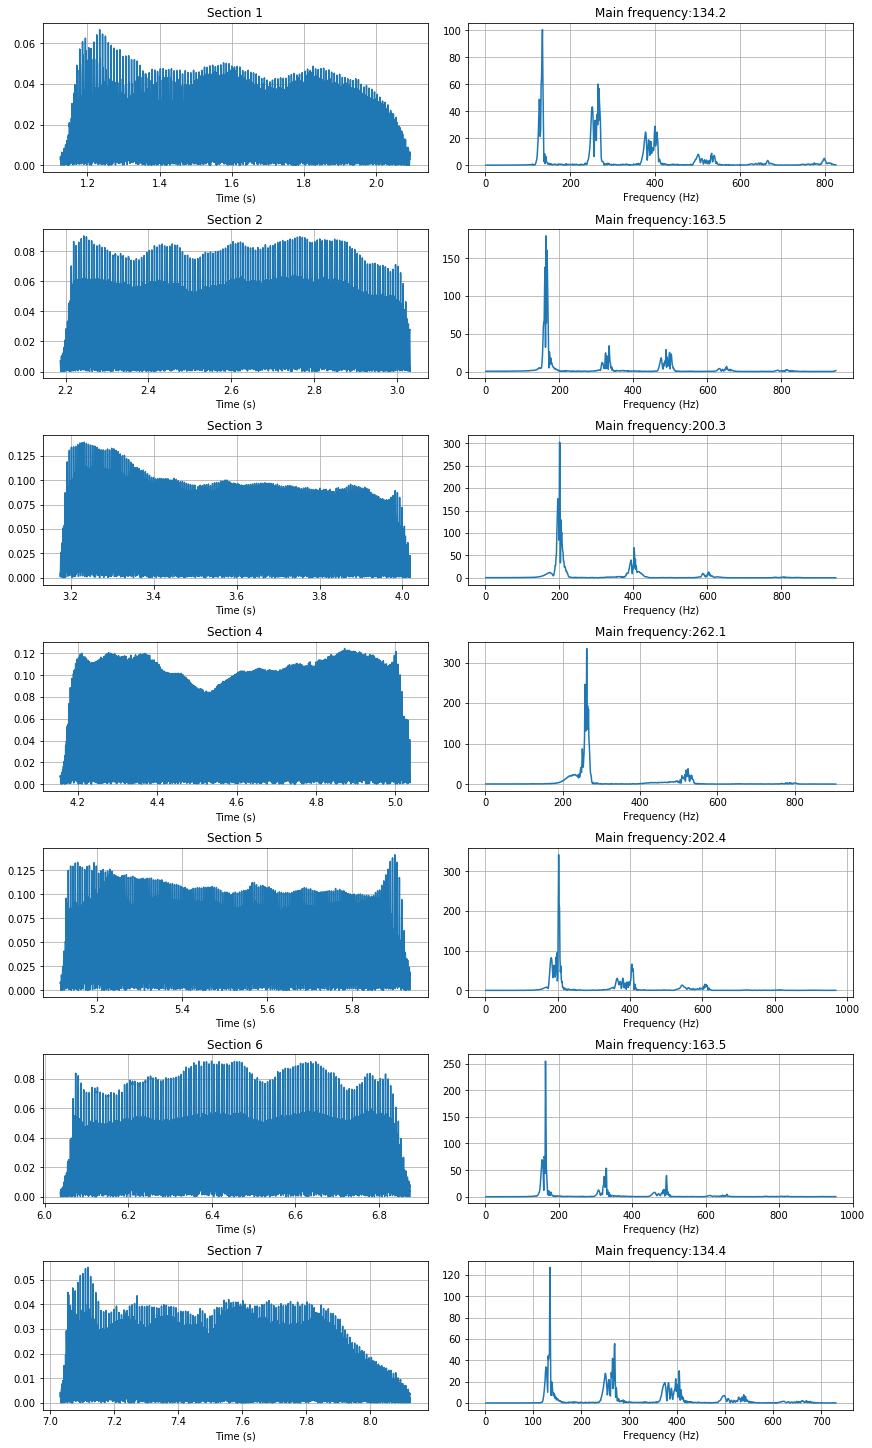

In [12]:
secs = [
    [18000, 33500],
    [35000, 48500],
    [50800, 64300],
    [66500, 80600],
    [81800, 95000],
    [96600, 110000],
    [112500, 130000]
]

num_secs = len(secs)

frecuencias = []

fig = plt.figure(constrained_layout=True, figsize = (12,20))

gs = gridspec.GridSpec(num_secs, 2, figure=fig)

for i in range(num_secs):

    ax0 = fig.add_subplot(gs[i, 0])
    ax1 = fig.add_subplot(gs[i, 1])

    subsignal = signal[secs[i][0]:secs[i][1]]
    Subsignal = np.fft.fft(subsignal)[1:800]
    f = np.linspace(0,sampling_rate,subsignal.shape[0])[1:800]
    ic = np.argmax(np.abs(Subsignal))
    fc = f[ic]
    frecuencias.append(fc)

    ax0.plot(t[secs[i][0]:secs[i][1]],np.abs(subsignal))
    ax0.set_xlabel('Time (s)')
    ax0.set_title('Section '+str(i+1))
    ax0.grid()

    ax1.plot(f,np.abs(Subsignal))
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_title('Main frequency:'+str(fc)[:5])
    ax1.grid()

This is off-key. Hence, we can correct it by shifting the frequency. First, we have to calculate the frequency shift according to the the frequency table and then shif the frequency accordingly. Once each section has been edited it is stored in the variables signal_cambiada_real y signal_cambiada_im.

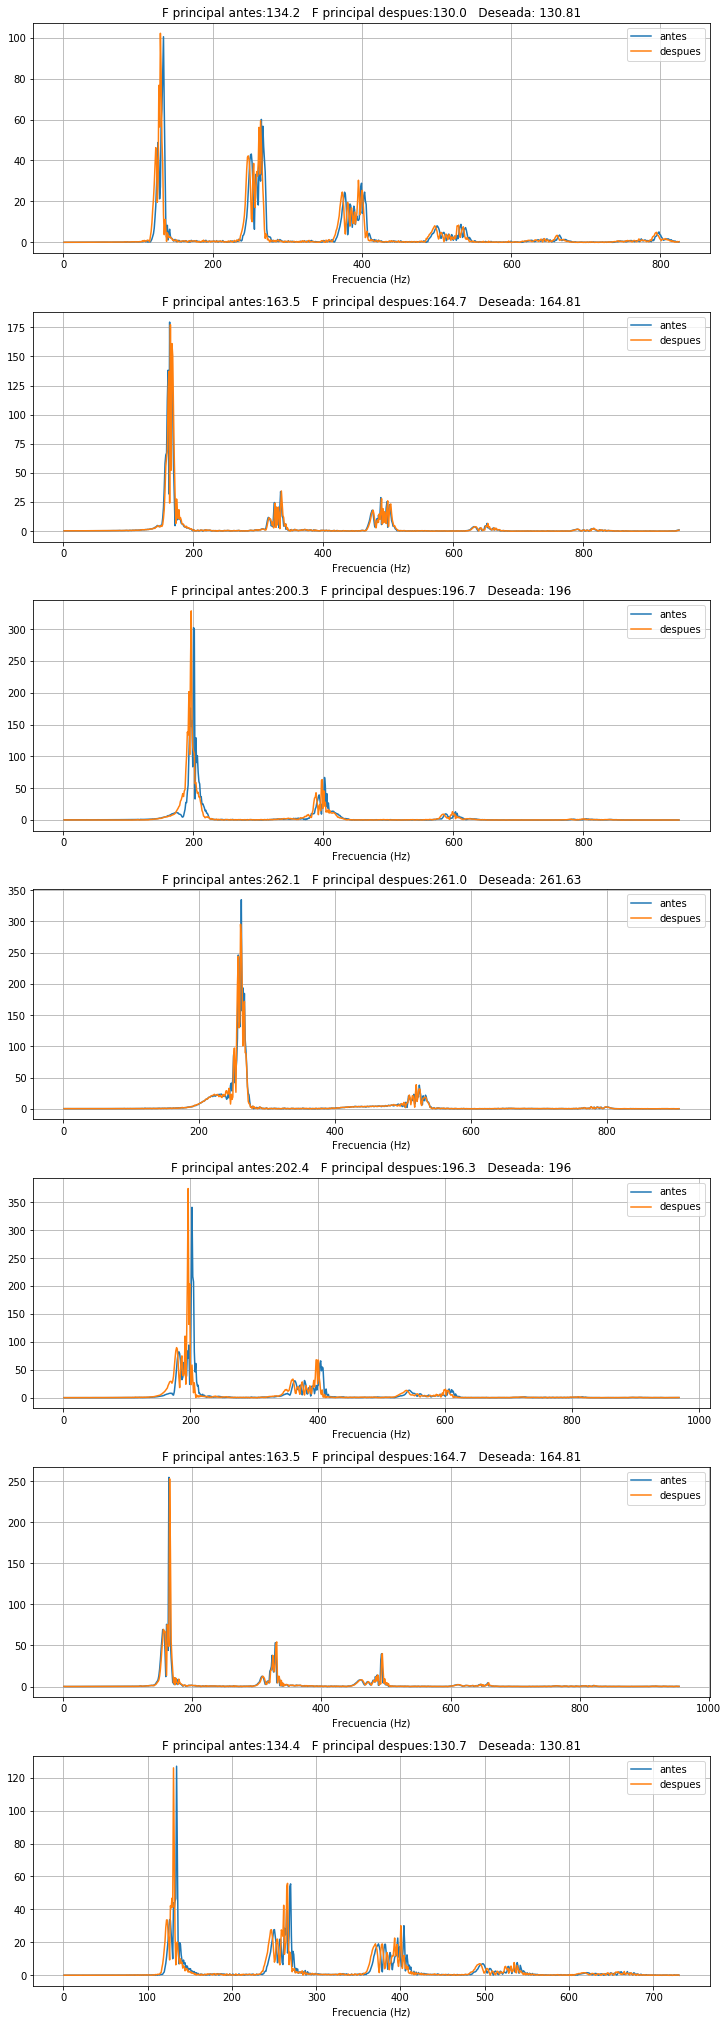

In [13]:
f_deseadas = [
    130.81,
    164.81,
    196,
    261.63,
    196,
    164.81,
    130.81
]

fig = plt.figure(constrained_layout=True, figsize = (10,28))

gs = gridspec.GridSpec(num_secs, 1, figure=fig)

for i in range(num_secs):

    ax = fig.add_subplot(gs[i, 0])

    subsignal = signal[secs[i][0]:secs[i][1]]
    Subsignal = np.fft.fft(subsignal)[1:800]
    f = np.linspace(0,sampling_rate,subsignal.shape[0])[1:800]
    ic = np.argmax(np.abs(Subsignal))
    fc = f[ic]
    
    ax.plot(f,np.abs(Subsignal), label = 'antes')
    
    f_cambio = f_deseadas[i] - fc

    signal_new = np.exp(2j*np.pi*f_cambio*t[secs[i][0]:secs[i][1]])*subsignal
    
    signal_cambiada_real[secs[i][0]:secs[i][1]] = signal_new.real
    signal_cambiada_im[secs[i][0]:secs[i][1]] = signal_new.imag

    Subsignal_new = np.fft.fft(signal_new)[1:800]
    ic = np.argmax(np.abs(Subsignal_new))
    fc_d = f[ic]
    
    ax.plot(f,np.abs(Subsignal_new), label = 'despues')
    
    ax.set_xlabel('Frecuencia (Hz)')
    ax.set_title('F principal antes:'+str(fc)[:5]+'   F principal despues:'+str(fc_d)[:5]+'   Deseada: '+str(f_deseadas[i]))
    ax.grid()
    ax.legend()

Finally, we save the new audio signal. The imaginary and the real parts become each channel (left and right).

In [14]:
wavio.write("aud1_cambiado.mp3", np.vstack((signal_cambiada_real, signal_cambiada_im)).T, sampling_rate, sampwidth=1)

## Audio signal 2 (Guitar)

The last process is repeated for the guitar audio. Nonetheless,  we have to take into account that the frequency component with the highest energy has not necesarily the lowest frequency.


In [15]:
signal, sampling_rate = open_audio('aud2.mp3')
total_size = signal.shape[0]
t = np.arange(0, total_size/sampling_rate, 1/sampling_rate)
inds = np.arange(0,total_size)

signal_cambiada_real = signal.copy()
signal_cambiada_im = signal.copy()

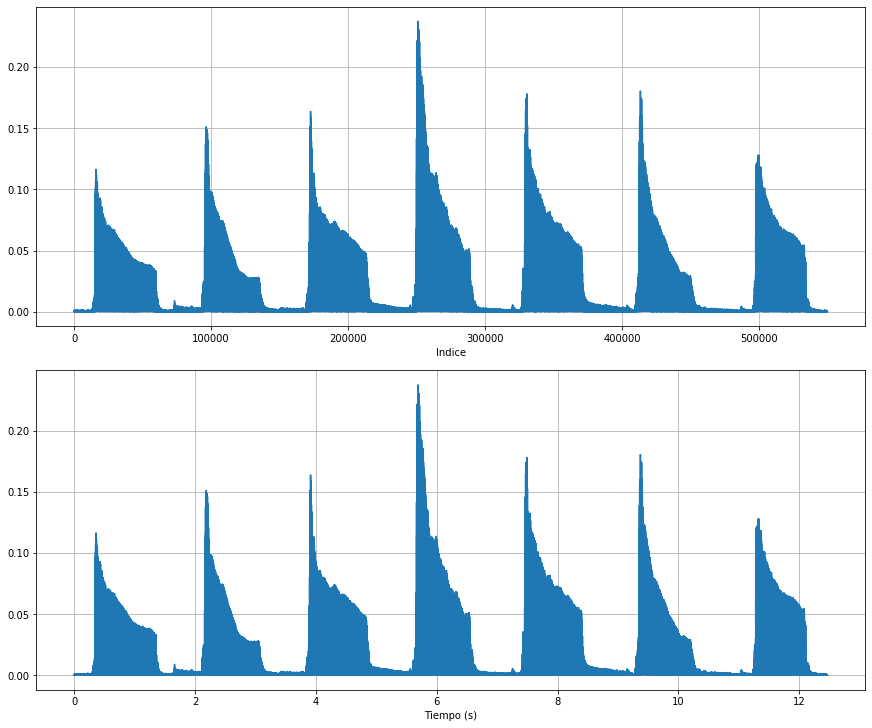

In [16]:
ini = 0
fin = total_size

fig, (ax0, ax1) = plt.subplots(nrows=2, constrained_layout=True, figsize = (12,10))

Mg = np.abs(signal)

ax0.plot(inds[ini:fin],Mg[ini:fin])
ax0.set_xlabel('Indice')
ax0.grid();

ax1.plot(t[ini:fin],Mg[ini:fin])
ax1.set_xlabel('Tiempo (s)')
ax1.grid();

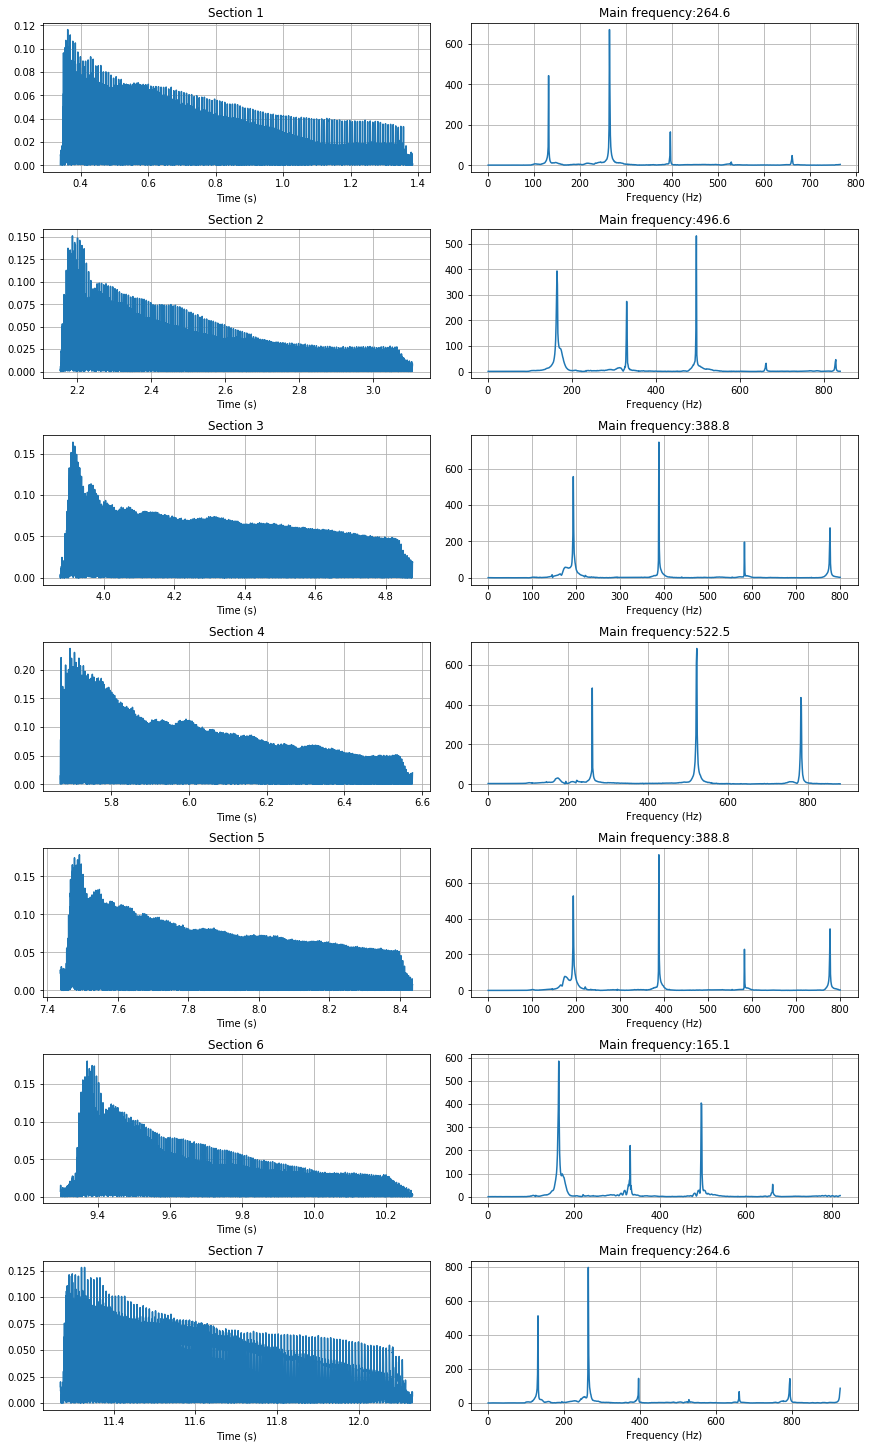

In [18]:
secs = [
    [15000, 61000],
    [95000, 137000],
    [171000, 215000],
    [250000, 290000],
    [328000, 372000],
    [410000, 453000],
    [497000, 535000]
]

num_secs = len(secs)

frecuencias = []

fig = plt.figure(constrained_layout=True, figsize = (12,20))

gs = gridspec.GridSpec(num_secs, 2, figure=fig)

for i in range(num_secs):

    ax0 = fig.add_subplot(gs[i, 0])
    ax1 = fig.add_subplot(gs[i, 1])

    subsignal = signal[secs[i][0]:secs[i][1]]
    Subsignal = np.fft.fft(subsignal)[1:800]
    f = np.linspace(0,sampling_rate,subsignal.shape[0])[1:800]
    ic = np.argmax(np.abs(Subsignal))
    fc = f[ic]
    frecuencias.append(fc)

    ax0.plot(t[secs[i][0]:secs[i][1]],np.abs(subsignal))
    ax0.set_xlabel('Time (s)')
    ax0.set_title('Section '+str(i+1))
    ax0.grid()

    ax1.plot(f,np.abs(Subsignal))
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_title('Main frequency:'+str(fc)[:5])
    ax1.grid()

The most significant frequency component are sometimes the second or third harmonic.

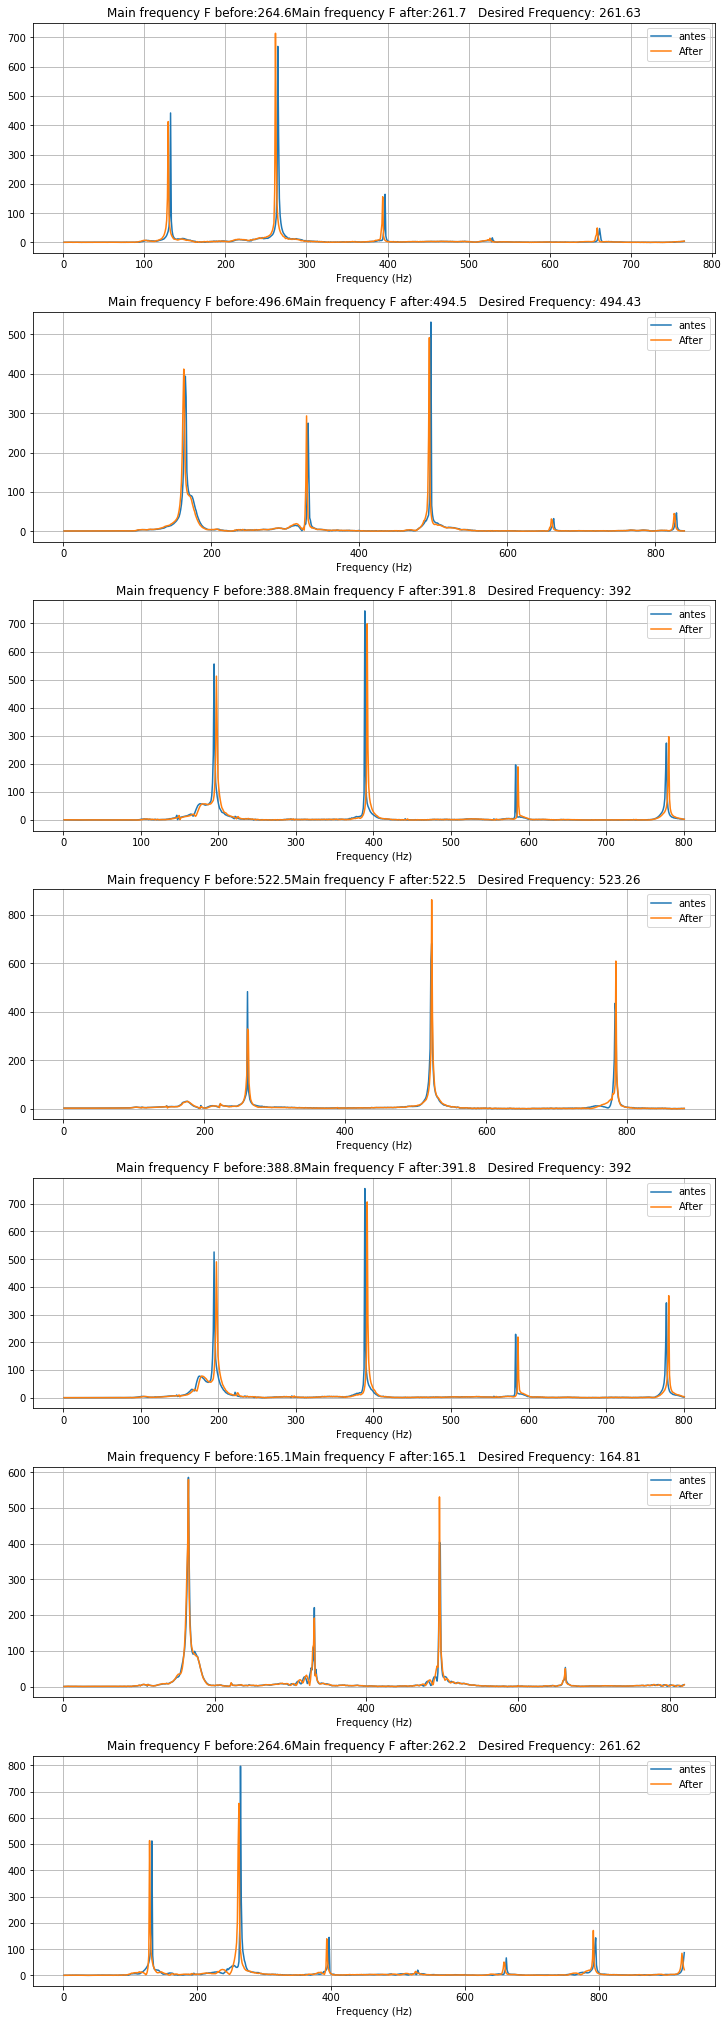

In [19]:
f_deseadas = [
    261.63, # 130.81*2
    494.43, # 164.81*3
    392, # 196*2
    523.26, # 261.63*2
    392, # 196*2
    164.81, 
    261.62 # 130.81*2
]

fig = plt.figure(constrained_layout=True, figsize = (10,28))

gs = gridspec.GridSpec(num_secs, 1, figure=fig)

for i in range(num_secs):

    ax = fig.add_subplot(gs[i, 0])

    subsignal = signal[secs[i][0]:secs[i][1]]
    Subsignal = np.fft.fft(subsignal)[1:800]
    f = np.linspace(0,sampling_rate,subsignal.shape[0])[1:800]
    ic = np.argmax(np.abs(Subsignal))
    fc = f[ic]
    
    ax.plot(f,np.abs(Subsignal), label = 'antes')
    
    f_cambio = f_deseadas[i] - fc

    signal_new = np.exp(2j*np.pi*f_cambio*t[secs[i][0]:secs[i][1]])*subsignal
    
    signal_cambiada_real[secs[i][0]:secs[i][1]] = signal_new.real
    signal_cambiada_im[secs[i][0]:secs[i][1]] = signal_new.imag

    Subsignal_new = np.fft.fft(signal_new)[1:800]
    ic = np.argmax(np.abs(Subsignal_new))
    fc_d = f[ic]
    
    ax.plot(f,np.abs(Subsignal_new), label = 'After')
    
    ax.set_xlabel('Frequency (Hz)')
    ax.set_title('Main frequency F before:'+str(fc)[:5]+'Main frequency F after:'+str(fc_d)[:5]+'   Desired Frequency: '+str(f_deseadas[i]))
    ax.grid()
    ax.legend()

In [21]:
wavio.write("aud2_cambiado.mp3", np.vstack((signal_cambiada_real, signal_cambiada_im)).T, sampling_rate, sampwidth=1)